# 1. Imports

In [1]:
# import sys
# from google.colab import drive

# drive.mount('/content/gdrive', force_remount=True)
# SRC_PATH = '/content/gdrive/MyDrive/MP FEB/FREDDIEMAC'
# DATA_SRC_PATH = SRC_PATH + "/data"
# sys.path.append(SRC_PATH)

# !pip install wandb -qqq
# import wandb
# wandb.login()

# !pip install dask[dataframe] -qqq
# !pip install fastparquet python-snappy -qqq
# import dask.dataframe as dd



# wandb.init(
#     # Set the project where this run will be logged
#     project="main_FREDDIEMAC", 
#     # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
#     #name="experiment 1"
#     # Track hyperparameters and run metadata
#     #config={
#       #"learning_rate": 0.02,
#       #"architecture": "CNN",
#       #"dataset": "CIFAR-100",
#       #"epochs": 10,}
#     )

In [2]:
DATA_SRC_PATH = "./data"

In [52]:
%load_ext autoreload
%autoreload 2

import dask.dataframe as dd
import os
import numpy as np
import pandas as pd
import torch
import copy

import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = 'cuda'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Import Dataset

### 2.1 Loading raw data

In [4]:
blumenstock_dynamic_types = {'LOAN_SEQUENCE_NUMBER': str, 'MONTHLY_REPORTING_PERIOD': str,'CURRENT_ACTUAL_UPB': float, 'CURRENT_LOAN_DELINQUENCY_STATUS': float, 
                    'CURRENT_INTEREST_RATE':float,'ELTV': float ,'LOAN_AGE': float, 'REMAINING_MONTHS_TO_LEGAL_MATURITY': float, 'CREDIT_SCORE': float,
                    'DTI': float, 'LTV': float, 'BAL_REPAID': float, 
                    'LABEL': float, "TIME_TO_EVENT": float, 'ORIGINAL_INTEREST_RATE': float, 'ORIGINAL_UPB': float, 'TOTAL_OBSERVED_LENGTH': float}

df_blumenstock_dynamic = dd.read_parquet(DATA_SRC_PATH + "/blumenstock_dynamic_labeled_sample_orig_*.parquet.gzip")
df_blumenstock_dynamic = df_blumenstock_dynamic.astype(blumenstock_dynamic_types)

print("This dataframe contains a total of %d entries" % len(df_blumenstock_dynamic))
print("This dataframe contains a total of %d loands" % len(df_blumenstock_dynamic["LOAN_SEQUENCE_NUMBER"].unique()))

This dataframe contains a total of 1734900 entries
This dataframe contains a total of 24614 loands


### 2.2 Normalising raw data

In [5]:
covariates_to_normalise = ['CURRENT_ACTUAL_UPB', 'CURRENT_LOAN_DELINQUENCY_STATUS', 'CURRENT_INTEREST_RATE', 'ELTV', 'LOAN_AGE', 'REMAINING_MONTHS_TO_LEGAL_MATURITY', 'CREDIT_SCORE',
                            'DTI', 'LTV', 'BAL_REPAID', 'ORIGINAL_INTEREST_RATE', 'ORIGINAL_UPB']

df_blumenstoch_dynamic_mean = df_blumenstock_dynamic[covariates_to_normalise].mean().compute()
df_blumenstoch_std = df_blumenstock_dynamic[covariates_to_normalise].std().compute()

df_blumenstock_dynamic[covariates_to_normalise] = (df_blumenstock_dynamic[covariates_to_normalise] - df_blumenstoch_dynamic_mean) / df_blumenstoch_std

### 2.3 Splitting train, validation and test-set

In [6]:
#TODO THESE SETS ARE OVERLAPPING!!!

AMOUNT_OF_TRAIN_LOANS = 2**12 + 1
AMOUNT_OF_VALIDATE_LOANS = 2**9 + 1
AMOUNT_OF_TEST_LOANS = 2**8 + 1

train_choices = np.random.choice(df_blumenstock_dynamic["LOAN_SEQUENCE_NUMBER"].unique(), AMOUNT_OF_TRAIN_LOANS, replace=False)
validate_choices = np.random.choice(df_blumenstock_dynamic["LOAN_SEQUENCE_NUMBER"].unique(), AMOUNT_OF_VALIDATE_LOANS, replace=False)
test_choices = np.random.choice(df_blumenstock_dynamic["LOAN_SEQUENCE_NUMBER"].unique(), AMOUNT_OF_TEST_LOANS, replace=False)

validate_df_blumenstock = df_blumenstock_dynamic[df_blumenstock_dynamic["LOAN_SEQUENCE_NUMBER"].isin(validate_choices)]
train_df_blumenstock = df_blumenstock_dynamic[df_blumenstock_dynamic["LOAN_SEQUENCE_NUMBER"].isin(train_choices)]
test_df_blumenstock = df_blumenstock_dynamic[df_blumenstock_dynamic["LOAN_SEQUENCE_NUMBER"].isin(test_choices)]

print("Total train set contains %d entries" % len(train_df_blumenstock))
print("Total validation set contains %d entries" % len(validate_df_blumenstock))
print("Total test set contains %d entries" % len(test_df_blumenstock))

print("------------------------------------------------------------------")
print("Total train set contains %d loans" % len(train_df_blumenstock["LOAN_SEQUENCE_NUMBER"].unique()))
print("Total validation set contains %d loans" % len(validate_df_blumenstock["LOAN_SEQUENCE_NUMBER"].unique()))
print("Total test set contains %d loans" % len(test_df_blumenstock["LOAN_SEQUENCE_NUMBER"].unique()))

Total train set contains 288310 entries
Total validation set contains 37827 entries
Total test set contains 17741 entries
------------------------------------------------------------------
Total train set contains 4097 loans
Total validation set contains 513 loans
Total test set contains 257 loans


### 2.4 Creating dataloaders

In [7]:
from torch.utils.data import DataLoader
from FREDDIEMAC_main_data import FREDDIEMAC_main_dataset, FREDDIEMAC_main_dataloader

BATCH_SIZE = 2**7

allowed_covariates = ['CURRENT_ACTUAL_UPB', 'CURRENT_LOAN_DELINQUENCY_STATUS', 'CURRENT_INTEREST_RATE', 'ELTV', 
                             'LOAN_AGE', 'REMAINING_MONTHS_TO_LEGAL_MATURITY', 'CREDIT_SCORE', 'DTI', 'LTV', 'BAL_REPAID', 
                             'ORIGINAL_INTEREST_RATE', 'ORIGINAL_UPB']

TOTAL_OBSERVED_LENGTH_covariate = 'TOTAL_OBSERVED_LENGTH'
TIME_TO_EVENT_covariate ='TIME_TO_EVENT'
LABEL_covariate = 'LABEL'

random_state = 123
augment = False
data_augment_factor = 3

print("batch_size = ", BATCH_SIZE)
print("number of covariates = ", len(allowed_covariates))

batch_size =  128
number of covariates =  12


#### 2.4.1 Creating train dataloader

In [8]:
augment_train_data = True

train_FREDDIEMAC_raw_dataset = FREDDIEMAC_main_dataset(train_df_blumenstock, 
                                                        allowed_covariates,
                                                        TIME_TO_EVENT_covariate,
                                                        TOTAL_OBSERVED_LENGTH_covariate,
                                                        LABEL_covariate,
                                                        frac_cases=1,
                                                        random_state=random_state,
                                                        test_set=False,
                                                        augment=augment_train_data,
                                                        data_augment_factor=data_augment_factor)

print("This dataset will contain %d samples" % len(train_FREDDIEMAC_raw_dataset))
train_data_loader = FREDDIEMAC_main_dataloader(dataset=train_FREDDIEMAC_raw_dataset, batch_size=BATCH_SIZE)
print("This dataloader will deliver %d batches" % train_data_loader.get_max_iterations())
batch_data, batch_data_length, batch_event, batch_tte = next(train_data_loader)

print(batch_data.shape)
print(batch_data_length.shape)
print(batch_event.shape)
print(batch_tte.shape)

This dataset will contain 16388 samples
This dataloader will deliver 128 batches
torch.Size([128, 180, 12])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


#### 2.4.2 Creating validate dataloader

In [9]:
augment_validate_data = False

validate_FREDDIEMAC_raw_dataset = FREDDIEMAC_main_dataset(validate_df_blumenstock, 
                                                            allowed_covariates,
                                                            TIME_TO_EVENT_covariate,
                                                            TOTAL_OBSERVED_LENGTH_covariate,
                                                            LABEL_covariate,
                                                            frac_cases=1,
                                                            random_state=random_state,
                                                            test_set=False,
                                                            augment=augment_validate_data,
                                                            data_augment_factor=data_augment_factor)

print("This dataset will contain %d samples" % len(validate_FREDDIEMAC_raw_dataset))
validate_data_loader = FREDDIEMAC_main_dataloader(dataset=validate_FREDDIEMAC_raw_dataset, batch_size=BATCH_SIZE)
print("This dataloader will deliver %d batches" % validate_data_loader.get_max_iterations())
batch_data, batch_data_length, batch_event, batch_tte = next(validate_data_loader)

print(batch_data.shape)
print(batch_data_length.shape)
print(batch_event.shape)
print(batch_tte.shape)

This dataset will contain 513 samples
This dataloader will deliver 4 batches
torch.Size([128, 180, 12])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


#### 2.4.3 Creating a test sample

In [10]:
augment_test_data = False

test_FREDDIEMAC_raw_dataset = FREDDIEMAC_main_dataset(test_df_blumenstock, 
                                                    allowed_covariates,
                                                    TIME_TO_EVENT_covariate,
                                                    TOTAL_OBSERVED_LENGTH_covariate,
                                                    LABEL_covariate,
                                                    frac_cases=1,
                                                    random_state=random_state,
                                                    test_set=False,
                                                    augment=augment_test_data,
                                                    data_augment_factor=data_augment_factor)

print("This dataset will contain %d samples" % len(test_FREDDIEMAC_raw_dataset))
test_data_loader = FREDDIEMAC_main_dataloader(dataset=test_FREDDIEMAC_raw_dataset, batch_size=BATCH_SIZE)
print("This dataloader will deliver %d batches" % test_data_loader.get_max_iterations())
batch_data, batch_data_length, batch_event, batch_tte = next(test_data_loader)

print(batch_data.shape)
print(batch_data_length.shape)
print(batch_event.shape)
print(batch_tte.shape)

This dataset will contain 257 samples
This dataloader will deliver 2 batches
torch.Size([128, 180, 12])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


### 2.5 Data Exploration

In [11]:
batch_data, batch_data_length, batch_event, batch_tte = next(iter(train_data_loader))

for i in range(min(BATCH_SIZE, 16)):
    print("batch event= %d --- batch_data_length= %d --- batch_tte= %d" % (batch_event[i], batch_data_length[i], batch_tte[i]))

batch event= 0 --- batch_data_length= 22 --- batch_tte= 94
batch event= 0 --- batch_data_length= 18 --- batch_tte= 18
batch event= 0 --- batch_data_length= 69 --- batch_tte= 69
batch event= 0 --- batch_data_length= 13 --- batch_tte= 13
batch event= 0 --- batch_data_length= 31 --- batch_tte= 31
batch event= 0 --- batch_data_length= 23 --- batch_tte= 23
batch event= 0 --- batch_data_length= 101 --- batch_tte= 121
batch event= 0 --- batch_data_length= 79 --- batch_tte= 79
batch event= 0 --- batch_data_length= 120 --- batch_tte= 120
batch event= 3 --- batch_data_length= 123 --- batch_tte= 123
batch event= 0 --- batch_data_length= 29 --- batch_tte= 29
batch event= 0 --- batch_data_length= 15 --- batch_tte= 15
batch event= 1 --- batch_data_length= 37 --- batch_tte= 110
batch event= 3 --- batch_data_length= 136 --- batch_tte= 136
batch event= 0 --- batch_data_length= 17 --- batch_tte= 31
batch event= 0 --- batch_data_length= 23 --- batch_tte= 23


# 3. Hyperparameters

In [12]:
from torch.optim import Adam

from dynamicDeepHit import EncoderRNN, AttnDecoderRNN, CauseSpecificSubnetwork, DynamicDeepHit
from losses import loss_1_batch, loss_2_batch, loss_3_batch

NUM_EPOCHS = 1

LEARNING_RATE_ENCODER = 0.001
LEARNING_RATE_DECODER = 0.001
LEARNING_RATE_CAUSESS = 0.0005

LOSS_1_AMPLIFIER = 1
LOSS_2_AMPLIFIER = 1
LOSS_3_AMPLIFIER = 1

RUN_VALIDATION_ROUND = True
RUN_VALIDATION_ROUND_BATCHES_THRESHOLD = 2**2
VAL_NUM_CASES_RUNTIME = BATCH_SIZE

input_size = train_FREDDIEMAC_raw_dataset.get_num_covariates()
output_size = train_FREDDIEMAC_raw_dataset.get_num_covariates()
MAX_LENGTH = train_FREDDIEMAC_raw_dataset.get_max_length()

NUM_CAUSES = 3
hidden_size_encoder = 256
hidden_size_attention = 512
fc_size_encoder = 512
SIGMA = 0.1

# 4. Defining The Model

In [13]:
# initialize model
encoder = EncoderRNN(input_size, hidden_size_encoder, fc_size_encoder).to(DEVICE)
decoder = AttnDecoderRNN(hidden_size_encoder, hidden_size_attention, output_size).to(DEVICE)
causess = CauseSpecificSubnetwork(hidden_size_encoder, input_size, MAX_LENGTH, NUM_CAUSES).to(DEVICE)
DDHT = DynamicDeepHit(encoder, decoder, causess, MAX_LENGTH, DEVICE)

# intialize optimizer
optimizer_encoder = Adam(encoder.parameters(), lr=LEARNING_RATE_ENCODER)
optimizer_decoder = Adam(decoder.parameters(), lr=LEARNING_RATE_DECODER)
optimizer_causess = Adam(causess.parameters(), lr=LEARNING_RATE_CAUSESS)

### 4.1 Testing a sample before training

For the first sample of the test batch:
sample has length 87
the model predicts the event 1 at time 21
probability of prepay event = 0.33
probability of default event = 0.33
probability of full repay event = 0.33


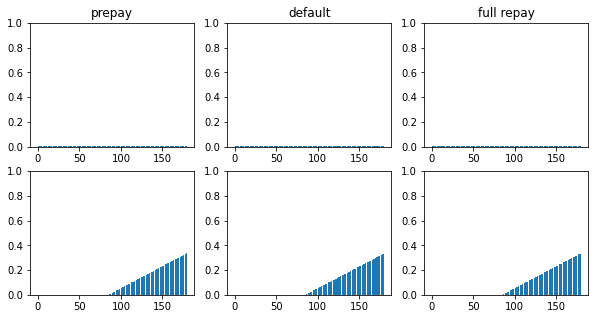

In [14]:
from utils import plot_fht_and_cif, plot_fht, plot_cif
from losses import CIF_K_tau

test_batch_data, test_batch_data_length, test_batch_event, test_batch_tte = next(iter(test_data_loader))

test_batch_data = test_batch_data.to(DEVICE)
test_batch_data_length = test_batch_data_length.to(DEVICE)
test_batch_event = test_batch_event.to(DEVICE)

DDHT.eval()

test_output, test_first_hitting_time, _ = DDHT(test_batch_data, test_batch_data_length)
test_first_hitting_time_argmax = test_first_hitting_time.argmax(dim=1)
model_event_prediction = test_first_hitting_time_argmax // MAX_LENGTH
model_tte_prediction = test_first_hitting_time_argmax % MAX_LENGTH

DDHT.train()

print("For the first sample of the test batch:")
print("sample has length %d" % test_batch_data_length[0])
print("the model predicts the event %d at time %d" % (model_event_prediction[0], model_tte_prediction[0] + 1))

print("probability of prepay event = %.2f" % CIF_K_tau(test_first_hitting_time[0], 0, MAX_LENGTH, test_batch_data_length[0], MAX_LENGTH).item())
print("probability of default event = %.2f" % CIF_K_tau(test_first_hitting_time[0], 1, MAX_LENGTH, test_batch_data_length[0], MAX_LENGTH).item())
print("probability of full repay event = %.2f" % CIF_K_tau(test_first_hitting_time[0], 2, MAX_LENGTH, test_batch_data_length[0], MAX_LENGTH).item())

plot_fht_and_cif(test_first_hitting_time[0], test_batch_data_length[0], MAX_LENGTH)

# 5. Training the model

In [15]:
from tqdm import trange

#PATH = "/content/gdrive/MyDrive/MP FEB/FREDDIEMAC/models/main_model_v1.pth"

# start training
for epoch in range(NUM_EPOCHS):

  epoch_loss = 0
  train_epoch_val_loss = 0
  train_epoch_val_loss1 = 0
  train_epoch_val_loss2 = 0

  for batch_number in trange(len(train_data_loader)):
    data = next(train_data_loader)

    batch_loss = 0

    optimizer_encoder.zero_grad()
    optimizer_decoder.zero_grad()
    optimizer_causess.zero_grad()

    batch_data, batch_data_length, batch_event, batch_tte = data
    batch_data = batch_data.to(DEVICE)
    batch_data_length = batch_data_length.to(DEVICE)
    batch_event = batch_event.to(DEVICE)
    batch_tte = batch_tte.to(DEVICE)
    
    output_batch, first_hitting_time_batch, _ = DDHT(batch_data, batch_data_length)

    loss1 = LOSS_1_AMPLIFIER*loss_1_batch(first_hitting_time_batch, batch_event, batch_tte, batch_data_length, MAX_LENGTH, DEVICE)
    loss2 = LOSS_2_AMPLIFIER*loss_2_batch(first_hitting_time_batch, batch_event, batch_tte, batch_data_length, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)
    loss3 = LOSS_3_AMPLIFIER*loss_3_batch(output_batch, batch_data.detach())

    batch_loss = loss1 + loss2 + loss3
    batch_loss.backward()

    epoch_loss += batch_loss.detach()

    #wandb.log({"train_loss1": loss1.item(), "train_loss2": loss2.item(), "train_loss3": loss3.item()})
    print({"train_loss1": loss1.item(), "train_loss2": loss2.item(), "train_loss3": loss3.item()})

    optimizer_encoder.step()
    optimizer_decoder.step()
    optimizer_causess.step()

    if RUN_VALIDATION_ROUND and batch_number % 5 == 0:
      # validation round
      # torch.save(DDHT.state_dict(), PATH)
      DDHT.eval()

      val_epoch_val_loss = 0
      val_epoch_val_loss1 = 0
      val_epoch_val_loss2 = 0
      val_epoch_val_loss3 = 0

      VAL_NUM_CASES_RUNTIME = len(validate_data_loader)*BATCH_SIZE
      for validation_batch_number in range(len(validate_data_loader)):
        data = next(validate_data_loader)

        with torch.no_grad():
          val_batch_data, val_batch_data_length, val_batch_event, val_batch_tte = next(iter(validate_data_loader))
          val_batch_data = val_batch_data.to(DEVICE)
          val_batch_data_length = val_batch_data_length.to(DEVICE)
          val_batch_event = val_batch_event.to(DEVICE)
          val_batch_tte = val_batch_tte.to(DEVICE)

          val_output_batch, val_first_hitting_time_batch, _ = DDHT(val_batch_data, val_batch_data_length)

          val_loss1 = LOSS_1_AMPLIFIER*loss_1_batch(val_first_hitting_time_batch, val_batch_event, val_batch_tte, val_batch_data_length, MAX_LENGTH, DEVICE)/VAL_NUM_CASES_RUNTIME
          val_loss2 = LOSS_2_AMPLIFIER*loss_2_batch(val_first_hitting_time_batch, val_batch_event, val_batch_tte, val_batch_data_length, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)/VAL_NUM_CASES_RUNTIME
          val_loss3 = LOSS_3_AMPLIFIER*loss_3_batch(val_output_batch, val_batch_data.detach())/VAL_NUM_CASES_RUNTIME

          val_epoch_val_loss1 += val_loss1
          val_epoch_val_loss2 += val_loss2
          val_epoch_val_loss3 += val_loss3
          val_epoch_val_loss = val_loss1 + val_loss2 + val_loss3

      #wandb.log({"val_epoch_val_loss1": val_epoch_val_loss1.item(), "val_epoch_val_loss2": val_epoch_val_loss2.item(), "val_epoch_val_loss3": val_epoch_val_loss3.item(), "val_epoch_val_loss": val_epoch_val_loss.item()})
      print({"val_epoch_val_loss1": val_epoch_val_loss1.item(), "val_epoch_val_loss2": val_epoch_val_loss2.item(), "val_epoch_val_loss3": val_epoch_val_loss3.item()})

      DDHT.train()
      # end validating round

  #wandb.log({"train_epoch_loss": epoch_loss.item()})
  #torch.save(DDHT.state_dict(), PATH)

#wandb.finish() 

  0%|          | 0/128 [00:00<?, ?it/s]

{'train_loss1': 628.7506103515625, 'train_loss2': 55.31229019165039, 'train_loss3': 0.2566455006599426}


  1%|          | 1/128 [04:40<9:54:03, 280.66s/it]

{'val_epoch_val_loss1': 4.56787109375, 'val_epoch_val_loss2': 0.44948649406433105, 'val_epoch_val_loss3': 0.002329139970242977}


  2%|▏         | 2/128 [06:05<7:45:54, 221.86s/it]

{'train_loss1': 627.7162475585938, 'train_loss2': 55.297935485839844, 'train_loss3': 0.24666158854961395}


  2%|▏         | 3/128 [07:31<6:17:28, 181.19s/it]

{'train_loss1': 626.7468872070312, 'train_loss2': 55.28244400024414, 'train_loss3': 0.23669028282165527}


  3%|▎         | 4/128 [08:58<5:16:16, 153.04s/it]

{'train_loss1': 625.75830078125, 'train_loss2': 55.267364501953125, 'train_loss3': 0.2248273342847824}


  4%|▍         | 5/128 [10:26<4:33:13, 133.28s/it]

{'train_loss1': 624.684326171875, 'train_loss2': 55.25088119506836, 'train_loss3': 0.21014165878295898}
{'train_loss1': 623.462158203125, 'train_loss2': 55.2308349609375, 'train_loss3': 0.19206948578357697}


  5%|▍         | 6/128 [15:10<6:03:08, 178.59s/it]

{'val_epoch_val_loss1': 4.5509867668151855, 'val_epoch_val_loss2': 0.4492051601409912, 'val_epoch_val_loss3': 0.0016744245076552033}


  5%|▌         | 7/128 [16:35<5:03:31, 150.51s/it]

{'train_loss1': 621.9849243164062, 'train_loss2': 55.20623016357422, 'train_loss3': 0.1706569939851761}


  6%|▋         | 8/128 [18:01<4:22:16, 131.14s/it]

{'train_loss1': 620.1361694335938, 'train_loss2': 55.174598693847656, 'train_loss3': 0.14688369631767273}


  7%|▋         | 9/128 [19:27<3:53:10, 117.57s/it]

{'train_loss1': 617.6350708007812, 'train_loss2': 55.12653732299805, 'train_loss3': 0.1244458556175232}


  8%|▊         | 10/128 [20:52<3:32:02, 107.82s/it]

{'train_loss1': 613.8824462890625, 'train_loss2': 55.049800872802734, 'train_loss3': 0.10924755036830902}
{'train_loss1': 607.7671508789062, 'train_loss2': 54.905555725097656, 'train_loss3': 0.10280801355838776}


  9%|▊         | 11/128 [25:46<5:19:26, 163.82s/it]

{'val_epoch_val_loss1': 4.457275390625, 'val_epoch_val_loss2': 0.4472387135028839, 'val_epoch_val_loss3': 0.0010337014682590961}


  9%|▉         | 12/128 [27:34<4:43:56, 146.86s/it]

{'train_loss1': 597.5022583007812, 'train_loss2': 54.6259880065918, 'train_loss3': 0.09742709994316101}


 10%|█         | 13/128 [29:20<4:18:11, 134.71s/it]

{'train_loss1': 579.1231689453125, 'train_loss2': 54.065399169921875, 'train_loss3': 0.092127725481987}


 11%|█         | 14/128 [31:00<3:56:12, 124.32s/it]

{'train_loss1': 551.0430297851562, 'train_loss2': 53.251033782958984, 'train_loss3': 0.08969734609127045}


 12%|█▏        | 15/128 [33:06<3:54:59, 124.78s/it]

{'train_loss1': 513.5868530273438, 'train_loss2': 53.2401008605957, 'train_loss3': 0.10140939056873322}
{'train_loss1': 481.6007385253906, 'train_loss2': 65.39212036132812, 'train_loss3': 0.11272917687892914}


 12%|█▎        | 16/128 [38:50<5:55:46, 190.59s/it]

{'val_epoch_val_loss1': 4.090019226074219, 'val_epoch_val_loss2': 0.38976383209228516, 'val_epoch_val_loss3': 0.0014729556860402226}


 13%|█▎        | 17/128 [40:35<5:05:00, 164.87s/it]

{'train_loss1': 464.4261474609375, 'train_loss2': 92.49665832519531, 'train_loss3': 0.13894891738891602}


 14%|█▍        | 18/128 [42:13<4:25:30, 144.83s/it]

{'train_loss1': 452.3216247558594, 'train_loss2': 79.53119659423828, 'train_loss3': 0.12249869853258133}


 15%|█▍        | 19/128 [43:39<3:51:00, 127.16s/it]

{'train_loss1': 445.7701110839844, 'train_loss2': 65.2091293334961, 'train_loss3': 0.10559868067502975}


 16%|█▌        | 20/128 [45:02<3:25:15, 114.04s/it]

{'train_loss1': 443.17523193359375, 'train_loss2': 58.133609771728516, 'train_loss3': 0.09383057057857513}
{'train_loss1': 439.65264892578125, 'train_loss2': 55.12553787231445, 'train_loss3': 0.08526472002267838}


 16%|█▋        | 21/128 [49:56<4:59:32, 167.96s/it]

{'val_epoch_val_loss1': 3.9139504432678223, 'val_epoch_val_loss2': 0.3927604556083679, 'val_epoch_val_loss3': 0.0008145233732648194}


 17%|█▋        | 22/128 [51:28<4:16:29, 145.18s/it]

{'train_loss1': 432.2257385253906, 'train_loss2': 54.429237365722656, 'train_loss3': 0.07689934223890305}


 18%|█▊        | 23/128 [52:58<3:45:07, 128.64s/it]

{'train_loss1': 420.300048828125, 'train_loss2': 55.72175979614258, 'train_loss3': 0.0725122019648552}


 19%|█▉        | 24/128 [54:26<3:21:55, 116.50s/it]

{'train_loss1': 405.1947021484375, 'train_loss2': 59.88248062133789, 'train_loss3': 0.07240734994411469}


 20%|█▉        | 25/128 [55:46<3:01:07, 105.51s/it]

{'train_loss1': 389.7802734375, 'train_loss2': 65.93173217773438, 'train_loss3': 0.06898912042379379}
{'train_loss1': 377.5267028808594, 'train_loss2': 68.16231536865234, 'train_loss3': 0.06328443437814713}


 20%|██        | 26/128 [1:00:22<4:26:03, 156.50s/it]

{'val_epoch_val_loss1': 3.929359197616577, 'val_epoch_val_loss2': 0.3589215576648712, 'val_epoch_val_loss3': 0.0006651963922195137}


 21%|██        | 27/128 [1:01:48<3:47:46, 135.31s/it]

{'train_loss1': 368.885986328125, 'train_loss2': 65.9910659790039, 'train_loss3': 0.06393695622682571}


 22%|██▏       | 28/128 [1:03:14<3:21:18, 120.78s/it]

{'train_loss1': 362.67816162109375, 'train_loss2': 62.70623016357422, 'train_loss3': 0.060831066220998764}


 23%|██▎       | 29/128 [1:04:41<3:02:10, 110.41s/it]

{'train_loss1': 356.8034362792969, 'train_loss2': 59.39484405517578, 'train_loss3': 0.05840427428483963}


 23%|██▎       | 30/128 [1:06:06<2:48:12, 102.98s/it]

{'train_loss1': 350.50543212890625, 'train_loss2': 56.283267974853516, 'train_loss3': 0.05610984191298485}
{'train_loss1': 343.5807189941406, 'train_loss2': 54.050148010253906, 'train_loss3': 0.05343765392899513}


 24%|██▍       | 31/128 [1:10:52<4:15:12, 157.86s/it]

{'val_epoch_val_loss1': 4.261011123657227, 'val_epoch_val_loss2': 0.3508845567703247, 'val_epoch_val_loss3': 0.0005715577281080186}


 25%|██▌       | 32/128 [1:12:17<3:37:39, 136.04s/it]

{'train_loss1': 336.63226318359375, 'train_loss2': 53.19214630126953, 'train_loss3': 0.05220538005232811}


 26%|██▌       | 33/128 [1:13:43<3:11:25, 120.90s/it]

{'train_loss1': 330.25885009765625, 'train_loss2': 52.70240783691406, 'train_loss3': 0.04971589148044586}


 27%|██▋       | 34/128 [1:15:08<2:52:29, 110.10s/it]

{'train_loss1': 326.2074890136719, 'train_loss2': 49.544395446777344, 'train_loss3': 0.047340426594018936}


 27%|██▋       | 35/128 [1:16:33<2:39:02, 102.61s/it]

{'train_loss1': 324.0347900390625, 'train_loss2': 45.740814208984375, 'train_loss3': 0.04542537406086922}
{'train_loss1': 319.3139343261719, 'train_loss2': 44.59125900268555, 'train_loss3': 0.04465341195464134}


 28%|██▊       | 36/128 [1:21:17<4:00:43, 157.00s/it]

{'val_epoch_val_loss1': 4.609470367431641, 'val_epoch_val_loss2': 0.3448335528373718, 'val_epoch_val_loss3': 0.0004518734640441835}


 29%|██▉       | 37/128 [1:22:42<3:25:17, 135.36s/it]

{'train_loss1': 310.1405029296875, 'train_loss2': 46.49935531616211, 'train_loss3': 0.04213858023285866}


 30%|██▉       | 38/128 [1:24:06<3:00:09, 120.10s/it]

{'train_loss1': 300.0372619628906, 'train_loss2': 49.37194061279297, 'train_loss3': 0.03990093991160393}


 30%|███       | 39/128 [1:25:31<2:42:34, 109.60s/it]

{'train_loss1': 292.47454833984375, 'train_loss2': 49.05801010131836, 'train_loss3': 0.0386633463203907}


 31%|███▏      | 40/128 [1:26:56<2:29:50, 102.17s/it]

{'train_loss1': 288.1558532714844, 'train_loss2': 45.26201248168945, 'train_loss3': 0.03719734773039818}
{'train_loss1': 283.2890930175781, 'train_loss2': 42.20923614501953, 'train_loss3': 0.036403875797986984}


 32%|███▏      | 41/128 [1:31:39<3:46:38, 156.31s/it]

{'val_epoch_val_loss1': 4.843923568725586, 'val_epoch_val_loss2': 0.33355513215065, 'val_epoch_val_loss3': 0.0003949255624320358}


 33%|███▎      | 42/128 [1:33:04<3:13:22, 134.91s/it]

{'train_loss1': 275.6966857910156, 'train_loss2': 42.21613693237305, 'train_loss3': 0.03585212305188179}


 34%|███▎      | 43/128 [1:34:30<2:50:13, 120.16s/it]

{'train_loss1': 267.2600402832031, 'train_loss2': 43.1729621887207, 'train_loss3': 0.034956712275743484}


 34%|███▍      | 44/128 [1:35:55<2:33:36, 109.72s/it]

{'train_loss1': 261.419677734375, 'train_loss2': 42.226139068603516, 'train_loss3': 0.033824022859334946}


 35%|███▌      | 45/128 [1:37:23<2:22:37, 103.10s/it]

{'train_loss1': 257.9347229003906, 'train_loss2': 37.97267532348633, 'train_loss3': 0.03451695665717125}
{'train_loss1': 254.28919982910156, 'train_loss2': 33.655670166015625, 'train_loss3': 0.03395292907953262}


 36%|███▌      | 46/128 [1:42:06<3:34:56, 157.28s/it]

{'val_epoch_val_loss1': 5.048059463500977, 'val_epoch_val_loss2': 0.31854262948036194, 'val_epoch_val_loss3': 0.00036691990680992603}


 37%|███▋      | 47/128 [1:43:32<3:03:20, 135.81s/it]

{'train_loss1': 248.45323181152344, 'train_loss2': 31.45456886291504, 'train_loss3': 0.03280194103717804}


 38%|███▊      | 48/128 [1:44:57<2:40:43, 120.55s/it]

{'train_loss1': 240.71609497070312, 'train_loss2': 31.047887802124023, 'train_loss3': 0.03410615772008896}


 38%|███▊      | 49/128 [1:46:23<2:24:57, 110.10s/it]

{'train_loss1': 232.82302856445312, 'train_loss2': 30.877702713012695, 'train_loss3': 0.03458656743168831}


 39%|███▉      | 50/128 [1:47:48<2:13:22, 102.59s/it]

{'train_loss1': 226.21900939941406, 'train_loss2': 28.840744018554688, 'train_loss3': 0.033318694680929184}
{'train_loss1': 219.2633056640625, 'train_loss2': 26.943157196044922, 'train_loss3': 0.034106723964214325}


 40%|███▉      | 51/128 [1:52:33<3:22:11, 157.55s/it]

{'val_epoch_val_loss1': 5.2687578201293945, 'val_epoch_val_loss2': 0.30829930305480957, 'val_epoch_val_loss3': 0.0003898767754435539}


 41%|████      | 52/128 [1:53:58<2:51:58, 135.77s/it]

{'train_loss1': 211.57550048828125, 'train_loss2': 25.4667911529541, 'train_loss3': 0.034575991332530975}


 41%|████▏     | 53/128 [1:55:23<2:30:39, 120.52s/it]

{'train_loss1': 202.71780395507812, 'train_loss2': 24.300033569335938, 'train_loss3': 0.03424832969903946}


 42%|████▏     | 54/128 [1:56:49<2:15:43, 110.05s/it]

{'train_loss1': 195.52879333496094, 'train_loss2': 21.010923385620117, 'train_loss3': 0.03402002528309822}


 43%|████▎     | 55/128 [1:58:15<2:05:08, 102.85s/it]

{'train_loss1': 186.03488159179688, 'train_loss2': 20.762971878051758, 'train_loss3': 0.03399251773953438}
{'train_loss1': 179.37242126464844, 'train_loss2': 17.649621963500977, 'train_loss3': 0.034396324306726456}


 44%|████▍     | 56/128 [2:02:58<3:08:26, 157.04s/it]

{'val_epoch_val_loss1': 5.559986591339111, 'val_epoch_val_loss2': 0.2967495322227478, 'val_epoch_val_loss3': 0.0003850085777230561}


 45%|████▍     | 57/128 [2:04:24<2:40:30, 135.63s/it]

{'train_loss1': 172.08787536621094, 'train_loss2': 16.50336456298828, 'train_loss3': 0.03445111960172653}


 45%|████▌     | 58/128 [2:05:49<2:20:29, 120.42s/it]

{'train_loss1': 167.16253662109375, 'train_loss2': 14.747133255004883, 'train_loss3': 0.03413323685526848}


 46%|████▌     | 59/128 [2:07:14<2:06:15, 109.78s/it]

{'train_loss1': 161.62969970703125, 'train_loss2': 12.42961597442627, 'train_loss3': 0.03433602303266525}


 47%|████▋     | 60/128 [2:08:40<1:56:18, 102.63s/it]

{'train_loss1': 154.51051330566406, 'train_loss2': 12.007006645202637, 'train_loss3': 0.03384482488036156}
{'train_loss1': 149.97781372070312, 'train_loss2': 11.06359577178955, 'train_loss3': 0.034678488969802856}


 48%|████▊     | 61/128 [2:13:23<2:54:54, 156.63s/it]

{'val_epoch_val_loss1': 5.841489791870117, 'val_epoch_val_loss2': 0.29228490591049194, 'val_epoch_val_loss3': 0.00038648085319437087}


 48%|████▊     | 62/128 [2:14:47<2:28:35, 135.08s/it]

{'train_loss1': 143.75840759277344, 'train_loss2': 15.124248504638672, 'train_loss3': 0.03367333486676216}


 49%|████▉     | 63/128 [2:16:12<2:10:02, 120.03s/it]

{'train_loss1': 146.33499145507812, 'train_loss2': 13.394929885864258, 'train_loss3': 0.03451588749885559}


 50%|█████     | 64/128 [2:17:37<1:56:46, 109.48s/it]

{'train_loss1': 141.0443572998047, 'train_loss2': 8.553671836853027, 'train_loss3': 0.03285522013902664}


 51%|█████     | 65/128 [2:19:03<1:47:32, 102.42s/it]

{'train_loss1': 143.3642578125, 'train_loss2': 11.082422256469727, 'train_loss3': 0.03221691772341728}
{'train_loss1': 129.8300018310547, 'train_loss2': 9.18167781829834, 'train_loss3': 0.03357737883925438}


 52%|█████▏    | 66/128 [2:23:45<2:41:33, 156.35s/it]

{'val_epoch_val_loss1': 6.079623222351074, 'val_epoch_val_loss2': 0.30298513174057007, 'val_epoch_val_loss3': 0.00040895643178373575}


 52%|█████▏    | 67/128 [2:25:10<2:17:00, 134.77s/it]

{'train_loss1': 129.5914306640625, 'train_loss2': 13.144548416137695, 'train_loss3': 0.034899767488241196}


 53%|█████▎    | 68/128 [2:26:35<1:59:47, 119.79s/it]

{'train_loss1': 121.77911376953125, 'train_loss2': 6.507997989654541, 'train_loss3': 0.03293229639530182}


 54%|█████▍    | 69/128 [2:28:00<1:47:30, 109.33s/it]

{'train_loss1': 126.24525451660156, 'train_loss2': 9.967462539672852, 'train_loss3': 0.03247414156794548}


 55%|█████▍    | 70/128 [2:29:25<1:38:41, 102.10s/it]

{'train_loss1': 119.58949279785156, 'train_loss2': 11.72510814666748, 'train_loss3': 0.03235894441604614}
{'train_loss1': 119.8428726196289, 'train_loss2': 5.778481483459473, 'train_loss3': 0.033879440277814865}


 55%|█████▌    | 71/128 [2:34:08<2:28:30, 156.32s/it]

{'val_epoch_val_loss1': 6.459268569946289, 'val_epoch_val_loss2': 0.3318358063697815, 'val_epoch_val_loss3': 0.0003589979314710945}


 56%|█████▋    | 72/128 [2:35:33<2:06:01, 135.04s/it]

{'train_loss1': 130.6694793701172, 'train_loss2': 19.232969284057617, 'train_loss3': 0.031203826889395714}


 57%|█████▋    | 73/128 [2:36:58<1:50:07, 120.14s/it]

{'train_loss1': 115.85746765136719, 'train_loss2': 6.29254150390625, 'train_loss3': 0.031477395445108414}


 58%|█████▊    | 74/128 [2:38:26<1:39:13, 110.25s/it]

{'train_loss1': 121.29750061035156, 'train_loss2': 12.479598999023438, 'train_loss3': 0.035052936524152756}


 59%|█████▊    | 75/128 [2:39:51<1:30:42, 102.68s/it]

{'train_loss1': 113.05756378173828, 'train_loss2': 6.83668851852417, 'train_loss3': 0.032340578734874725}
{'train_loss1': 111.01403045654297, 'train_loss2': 6.654021739959717, 'train_loss3': 0.028826339170336723}


 59%|█████▉    | 76/128 [2:44:33<2:15:37, 156.49s/it]

{'val_epoch_val_loss1': 6.520016193389893, 'val_epoch_val_loss2': 0.323869526386261, 'val_epoch_val_loss3': 0.0003791578346863389}


 60%|██████    | 77/128 [2:45:57<1:54:44, 134.98s/it]

{'train_loss1': 108.06346130371094, 'train_loss2': 6.948008060455322, 'train_loss3': 0.03190474957227707}


 61%|██████    | 78/128 [2:47:23<1:40:01, 120.02s/it]

{'train_loss1': 103.41912841796875, 'train_loss2': 5.825191974639893, 'train_loss3': 0.03327801823616028}


 62%|██████▏   | 79/128 [2:48:48<1:29:31, 109.63s/it]

{'train_loss1': 102.6971664428711, 'train_loss2': 5.757481575012207, 'train_loss3': 0.028702938929200172}


 62%|██████▎   | 80/128 [2:50:14<1:22:02, 102.55s/it]

{'train_loss1': 98.89088439941406, 'train_loss2': 6.494470596313477, 'train_loss3': 0.02620483748614788}
{'train_loss1': 94.51744079589844, 'train_loss2': 5.125163555145264, 'train_loss3': 0.030053669586777687}


 63%|██████▎   | 81/128 [2:54:57<2:02:49, 156.80s/it]

{'val_epoch_val_loss1': 6.561703205108643, 'val_epoch_val_loss2': 0.31578314304351807, 'val_epoch_val_loss3': 0.00033673449070192873}


 64%|██████▍   | 82/128 [2:56:22<1:43:38, 135.19s/it]

{'train_loss1': 92.90110778808594, 'train_loss2': 5.1031389236450195, 'train_loss3': 0.029625853523612022}


 65%|██████▍   | 83/128 [2:57:47<1:30:10, 120.24s/it]

{'train_loss1': 90.33954620361328, 'train_loss2': 3.196967124938965, 'train_loss3': 0.02520584687590599}


 66%|██████▌   | 84/128 [2:59:14<1:20:48, 110.19s/it]

{'train_loss1': 87.98928833007812, 'train_loss2': 3.144655227661133, 'train_loss3': 0.02373637817800045}


 66%|██████▋   | 85/128 [3:00:40<1:13:39, 102.79s/it]

{'train_loss1': 86.34259796142578, 'train_loss2': 3.5393013954162598, 'train_loss3': 0.026030249893665314}
{'train_loss1': 82.80712127685547, 'train_loss2': 3.1145670413970947, 'train_loss3': 0.02644064649939537}


 67%|██████▋   | 86/128 [3:05:23<1:49:48, 156.87s/it]

{'val_epoch_val_loss1': 6.673013687133789, 'val_epoch_val_loss2': 0.32466238737106323, 'val_epoch_val_loss3': 0.00027225568192079663}


 68%|██████▊   | 87/128 [3:06:48<1:32:27, 135.32s/it]

{'train_loss1': 79.98052978515625, 'train_loss2': 2.733099937438965, 'train_loss3': 0.023380329832434654}


 69%|██████▉   | 88/128 [3:08:14<1:20:28, 120.72s/it]

{'train_loss1': 77.75745391845703, 'train_loss2': 2.534294366836548, 'train_loss3': 0.021391579881310463}


 70%|██████▉   | 89/128 [3:09:39<1:11:26, 109.91s/it]

{'train_loss1': 76.01598358154297, 'train_loss2': 2.820831537246704, 'train_loss3': 0.021892480552196503}


 70%|███████   | 90/128 [3:11:05<1:04:58, 102.58s/it]

{'train_loss1': 74.10173797607422, 'train_loss2': 2.6962592601776123, 'train_loss3': 0.022854525595903397}
{'train_loss1': 71.42822265625, 'train_loss2': 2.023618221282959, 'train_loss3': 0.022647345438599586}


 71%|███████   | 91/128 [3:15:45<1:36:13, 156.05s/it]

{'val_epoch_val_loss1': 6.849954605102539, 'val_epoch_val_loss2': 0.3323914110660553, 'val_epoch_val_loss3': 0.0002455232897773385}


 72%|███████▏  | 92/128 [3:17:10<1:20:42, 134.51s/it]

{'train_loss1': 69.9892349243164, 'train_loss2': 1.7493702173233032, 'train_loss3': 0.020332887768745422}


 73%|███████▎  | 93/128 [3:18:35<1:09:47, 119.64s/it]

{'train_loss1': 68.21525573730469, 'train_loss2': 1.6581629514694214, 'train_loss3': 0.019004015251994133}


 73%|███████▎  | 94/128 [3:19:59<1:01:53, 109.21s/it]

{'train_loss1': 65.79643249511719, 'train_loss2': 1.7267009019851685, 'train_loss3': 0.01948181912302971}


 74%|███████▍  | 95/128 [3:21:25<56:06, 102.00s/it]  

{'train_loss1': 63.207244873046875, 'train_loss2': 1.5625650882720947, 'train_loss3': 0.0202550757676363}
{'train_loss1': 61.434539794921875, 'train_loss2': 1.4327056407928467, 'train_loss3': 0.01924053020775318}


 75%|███████▌  | 96/128 [3:26:08<1:23:20, 156.26s/it]

{'val_epoch_val_loss1': 6.956507682800293, 'val_epoch_val_loss2': 0.3375850021839142, 'val_epoch_val_loss3': 0.00021821478730998933}


 76%|███████▌  | 97/128 [3:27:33<1:09:42, 134.92s/it]

{'train_loss1': 59.717403411865234, 'train_loss2': 1.3223625421524048, 'train_loss3': 0.017550723627209663}


 77%|███████▋  | 98/128 [3:28:58<59:58, 119.94s/it]  

{'train_loss1': 58.584041595458984, 'train_loss2': 1.2423840761184692, 'train_loss3': 0.017241280525922775}


 77%|███████▋  | 99/128 [3:30:22<52:51, 109.36s/it]

{'train_loss1': 56.66819381713867, 'train_loss2': 1.1006214618682861, 'train_loss3': 0.018189111724495888}


 78%|███████▊  | 100/128 [3:31:48<47:42, 102.25s/it]

{'train_loss1': 54.8043327331543, 'train_loss2': 0.9183792471885681, 'train_loss3': 0.018007341772317886}
{'train_loss1': 52.55982208251953, 'train_loss2': 0.9216781258583069, 'train_loss3': 0.016982562839984894}


 79%|███████▉  | 101/128 [3:36:31<1:10:25, 156.48s/it]

{'val_epoch_val_loss1': 7.129364490509033, 'val_epoch_val_loss2': 0.34548044204711914, 'val_epoch_val_loss3': 0.0002069369948003441}


 80%|███████▉  | 102/128 [3:37:59<58:51, 135.84s/it]  

{'train_loss1': 51.9246711730957, 'train_loss2': 0.8961731791496277, 'train_loss3': 0.016495056450366974}


 80%|████████  | 103/128 [3:39:23<50:12, 120.51s/it]

{'train_loss1': 49.12801742553711, 'train_loss2': 0.6799159646034241, 'train_loss3': 0.016634391620755196}


 81%|████████▏ | 104/128 [3:40:48<43:50, 109.61s/it]

{'train_loss1': 47.9202880859375, 'train_loss2': 0.613908052444458, 'train_loss3': 0.016775529831647873}


 82%|████████▏ | 105/128 [3:42:13<39:12, 102.28s/it]

{'train_loss1': 46.19974899291992, 'train_loss2': 0.5499712824821472, 'train_loss3': 0.01618022657930851}
{'train_loss1': 45.38690185546875, 'train_loss2': 0.5811553597450256, 'train_loss3': 0.01585656963288784}


 83%|████████▎ | 106/128 [3:46:55<57:17, 156.24s/it]

{'val_epoch_val_loss1': 7.243038177490234, 'val_epoch_val_loss2': 0.34950321912765503, 'val_epoch_val_loss3': 0.00020033837063238025}


 84%|████████▎ | 107/128 [3:48:20<47:13, 134.95s/it]

{'train_loss1': 44.1070671081543, 'train_loss2': 0.48951318860054016, 'train_loss3': 0.015794744715094566}


 84%|████████▍ | 108/128 [3:49:45<39:57, 119.89s/it]

{'train_loss1': 42.77387237548828, 'train_loss2': 0.5151048898696899, 'train_loss3': 0.015637239441275597}


 85%|████████▌ | 109/128 [3:51:11<34:44, 109.73s/it]

{'train_loss1': 41.034278869628906, 'train_loss2': 0.4373076260089874, 'train_loss3': 0.01535012200474739}


 86%|████████▌ | 110/128 [3:52:36<30:39, 102.20s/it]

{'train_loss1': 39.666961669921875, 'train_loss2': 0.3681623935699463, 'train_loss3': 0.015407189726829529}
{'train_loss1': 38.641902923583984, 'train_loss2': 0.30144160985946655, 'train_loss3': 0.01534680649638176}


 87%|████████▋ | 111/128 [3:57:19<44:22, 156.60s/it]

{'val_epoch_val_loss1': 7.381097316741943, 'val_epoch_val_loss2': 0.3550938665866852, 'val_epoch_val_loss3': 0.00019096954201813787}


 88%|████████▊ | 112/128 [3:58:45<36:06, 135.40s/it]

{'train_loss1': 37.04376983642578, 'train_loss2': 0.2546240985393524, 'train_loss3': 0.014762350358068943}


 88%|████████▊ | 113/128 [4:00:10<30:02, 120.18s/it]

{'train_loss1': 35.563838958740234, 'train_loss2': 0.22501254081726074, 'train_loss3': 0.014744878746569157}


 89%|████████▉ | 114/128 [4:01:35<25:35, 109.66s/it]

{'train_loss1': 34.82384490966797, 'train_loss2': 0.20003585517406464, 'train_loss3': 0.015044725500047207}


 90%|████████▉ | 115/128 [4:02:59<22:07, 102.12s/it]

{'train_loss1': 33.629539489746094, 'train_loss2': 0.19501575827598572, 'train_loss3': 0.014644264243543148}
{'train_loss1': 32.39836502075195, 'train_loss2': 0.15632934868335724, 'train_loss3': 0.014176926575601101}


 91%|█████████ | 116/128 [4:07:42<31:13, 156.13s/it]

{'val_epoch_val_loss1': 7.4926557540893555, 'val_epoch_val_loss2': 0.35765495896339417, 'val_epoch_val_loss3': 0.00018434520461596549}


 91%|█████████▏| 117/128 [4:09:06<24:41, 134.66s/it]

{'train_loss1': 32.10240936279297, 'train_loss2': 0.21599985659122467, 'train_loss3': 0.014272592030465603}


 92%|█████████▏| 118/128 [4:10:31<19:56, 119.64s/it]

{'train_loss1': 30.187789916992188, 'train_loss2': 0.15137635171413422, 'train_loss3': 0.01423102430999279}


 93%|█████████▎| 119/128 [4:11:55<16:22, 109.12s/it]

{'train_loss1': 29.009361267089844, 'train_loss2': 0.12468042224645615, 'train_loss3': 0.01403615903109312}


 94%|█████████▍| 120/128 [4:13:20<13:35, 101.90s/it]

{'train_loss1': 28.143733978271484, 'train_loss2': 0.1046219989657402, 'train_loss3': 0.01373286172747612}
{'train_loss1': 27.163394927978516, 'train_loss2': 0.07695765048265457, 'train_loss3': 0.013549711555242538}


 95%|█████████▍| 121/128 [4:18:04<18:14, 156.32s/it]

{'val_epoch_val_loss1': 7.623055934906006, 'val_epoch_val_loss2': 0.3623765707015991, 'val_epoch_val_loss3': 0.00017940939869731665}


 95%|█████████▌| 122/128 [4:19:28<13:28, 134.73s/it]

{'train_loss1': 26.89617919921875, 'train_loss2': 0.08615821599960327, 'train_loss3': 0.013521471992135048}


 96%|█████████▌| 123/128 [4:20:53<09:59, 119.94s/it]

{'train_loss1': 25.84109878540039, 'train_loss2': 0.07991108298301697, 'train_loss3': 0.013552723452448845}


 97%|█████████▋| 124/128 [4:22:18<07:17, 109.37s/it]

{'train_loss1': 24.873430252075195, 'train_loss2': 0.06910640001296997, 'train_loss3': 0.013384714722633362}


 98%|█████████▊| 125/128 [4:23:43<05:05, 101.94s/it]

{'train_loss1': 23.75782012939453, 'train_loss2': 0.06521859019994736, 'train_loss3': 0.013193641789257526}
{'train_loss1': 22.84764289855957, 'train_loss2': 0.0531647726893425, 'train_loss3': 0.013195449486374855}


 98%|█████████▊| 126/128 [4:28:24<05:11, 155.82s/it]

{'val_epoch_val_loss1': 7.733063697814941, 'val_epoch_val_loss2': 0.3646163046360016, 'val_epoch_val_loss3': 0.00017321965424343944}


 99%|█████████▉| 127/128 [4:29:48<02:14, 134.18s/it]

{'train_loss1': 22.674379348754883, 'train_loss2': 0.04937565699219704, 'train_loss3': 0.013067620806396008}


100%|██████████| 128/128 [4:31:12<00:00, 127.13s/it]

{'train_loss1': 21.527772903442383, 'train_loss2': 0.0485013984143734, 'train_loss3': 0.013077117502689362}


# 6. Testing the models performance

In [69]:
#PATH = "/content/gdrive/MyDrive/MP FEB/FREDDIEMAC/models/main_model_v1.pth"
PATH = "models/main_model_local_v1.pth"
torch.save(DDHT.state_dict(), PATH)
DDHT.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
test_sample_index = 0

### 6.1 Testing a sample after training

For the first sample of the test batch:
sample has length 23
the model predicts the event 0 at time 14
probability of prepay event = 1.00
probability of default event = 0.00
probability of full repay event = 0.00


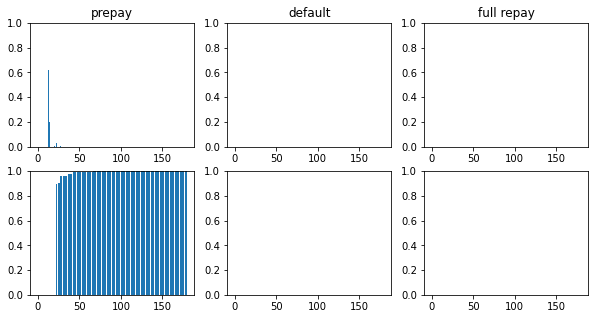

In [70]:
from utils import plot_fht_and_cif, plot_fht, plot_cif
from losses import CIF_K_tau

test_batch_data, test_batch_data_length, test_batch_event, test_batch_tte = next(iter(test_data_loader))

test_batch_data = test_batch_data.to(DEVICE)
test_batch_data_length = test_batch_data_length.to(DEVICE)
test_batch_event = test_batch_event.to(DEVICE)

DDHT.eval()

test_output, test_first_hitting_time, test_attention_weights = DDHT(test_batch_data, test_batch_data_length)
test_first_hitting_time_argmax = test_first_hitting_time.argmax(dim=1)
model_event_prediction = test_first_hitting_time_argmax // MAX_LENGTH
model_tte_prediction = test_first_hitting_time_argmax % MAX_LENGTH

print("For the first sample of the test batch:")
print("sample has length %d" % test_batch_data_length[test_sample_index])
print("the model predicts the event %d at time %d" % (model_event_prediction[test_sample_index], model_tte_prediction[test_sample_index] + 1))

print("probability of prepay event = %.2f" % CIF_K_tau(test_first_hitting_time[test_sample_index], 0, MAX_LENGTH, test_batch_data_length[test_sample_index], MAX_LENGTH).item())
print("probability of default event = %.2f" % CIF_K_tau(test_first_hitting_time[test_sample_index], 1, MAX_LENGTH, test_batch_data_length[test_sample_index], MAX_LENGTH).item())
print("probability of full repay event = %.2f" % CIF_K_tau(test_first_hitting_time[test_sample_index], 2, MAX_LENGTH, test_batch_data_length[test_sample_index], MAX_LENGTH).item())

plot_fht_and_cif(test_first_hitting_time[test_sample_index], test_batch_data_length[test_sample_index], MAX_LENGTH)

### 6.2 Testing more samples

In [78]:
for test_sample_index in range(2**3):
  print("--------------------------------------------")
  print("sample will experiece event: %d - at time %d" % (test_batch_event[test_sample_index], test_batch_data_length[test_sample_index]))
  print("model will predict event:    %d - at time %d" % (model_event_prediction[test_sample_index], model_tte_prediction[test_sample_index]))

--------------------------------------------
sample will experiece event: 0 - at time 22
model will predict event:    0 - at time 20
--------------------------------------------
sample will experiece event: 0 - at time 18
model will predict event:    0 - at time 16
--------------------------------------------
sample will experiece event: 0 - at time 69
model will predict event:    0 - at time 18
--------------------------------------------
sample will experiece event: 0 - at time 13
model will predict event:    0 - at time 11
--------------------------------------------
sample will experiece event: 0 - at time 31
model will predict event:    0 - at time 11
--------------------------------------------
sample will experiece event: 0 - at time 23
model will predict event:    0 - at time 13
--------------------------------------------
sample will experiece event: 0 - at time 101
model will predict event:    0 - at time 22
--------------------------------------------
sample will experiece e

### 6.3 Plotting a confusion matrix

[1.         0.33333333 0.        ]


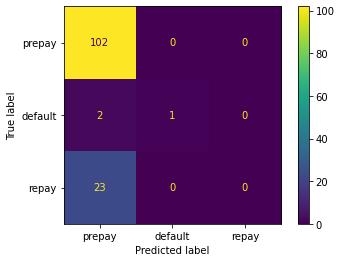

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

a = test_batch_event.flatten().cpu()
b = model_event_prediction.cpu()

cm = confusion_matrix(a, b)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['prepay', 'default', 'repay'])
accuracy = cm.diagonal()/cm.sum(axis=1)

print(accuracy)

disp.plot()
plt.show()

# 7. Analysing the model 

### 7.1 Which attention weights are the most important?

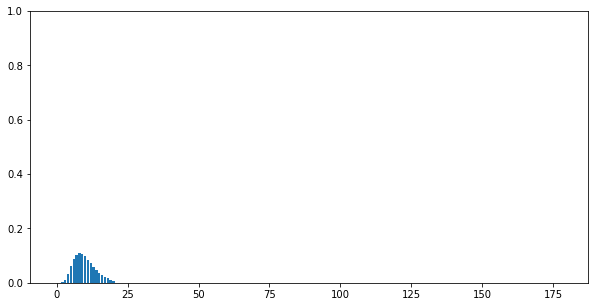

In [29]:
from utils import plot_attention_weights
plot_attention_weights(test_attention_weights[test_sample_index])

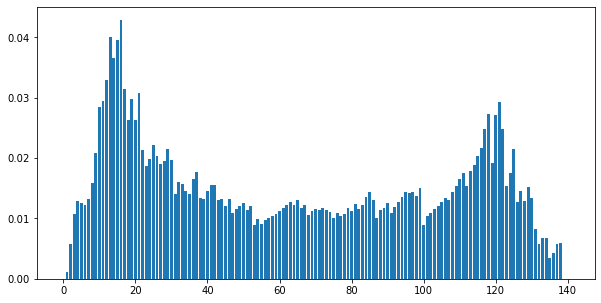

In [61]:
from utils import plot_attention_weights_batch

plot_attention_weights_batch(test_attention_weights, test_batch_data_length, normalised=True, y_lim=None)

### 7.2 What does the model do when we mask some covariates

from the allowed covariates:  ['CURRENT_ACTUAL_UPB', 'CURRENT_LOAN_DELINQUENCY_STATUS', 'CURRENT_INTEREST_RATE', 'ELTV', 'LOAN_AGE', 'REMAINING_MONTHS_TO_LEGAL_MATURITY', 'CREDIT_SCORE', 'DTI', 'LTV', 'BAL_REPAID', 'ORIGINAL_INTEREST_RATE', 'ORIGINAL_UPB']
we masked the following covariates:  ['LOAN_AGE', 'REMAINING_MONTHS_TO_LEGAL_MATURITY']
For the first sample of the test batch:
sample has length 22
the model predicts the event 0 at time 21
probability of prepay event = 0.99
probability of default event = 0.01
probability of full repay event = 0.00


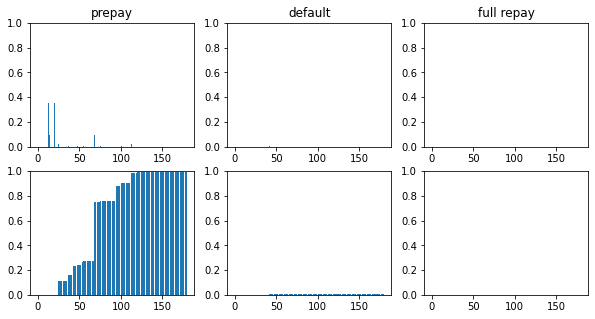

In [41]:
test_batch_data, test_batch_data_length, test_batch_event, test_batch_tte = next(iter(test_data_loader))

test_batch_data = test_batch_data.to(DEVICE)
test_batch_data_length = test_batch_data_length.to(DEVICE)
test_batch_event = test_batch_event.to(DEVICE)

masked_data = copy.deepcopy(test_batch_data)
masked_covariates = ['LOAN_AGE', 'REMAINING_MONTHS_TO_LEGAL_MATURITY']

for covariate in masked_covariates:
  masked_data[:,:,allowed_covariates.index(covariate)] = 0.0

masked_data = masked_data.to(DEVICE)

test_output, test_first_hitting_time, test_attention_weights = DDHT(masked_data, test_batch_data_length)
test_first_hitting_time_argmax = test_first_hitting_time.argmax(dim=1)
model_event_prediction = test_first_hitting_time_argmax // MAX_LENGTH
model_tte_prediction = test_first_hitting_time_argmax % MAX_LENGTH


print("from the allowed covariates: ", allowed_covariates)
print("we masked the following covariates: ", masked_covariates)

print("For the first sample of the test batch:")
print("sample has length %d" % test_batch_data_length[test_sample_index])
print("the model predicts the event %d at time %d" % (model_event_prediction[test_sample_index], model_tte_prediction[test_sample_index] + 1))

print("probability of prepay event = %.2f" % CIF_K_tau(test_first_hitting_time[test_sample_index], 0, MAX_LENGTH, test_batch_data_length[test_sample_index], MAX_LENGTH).item())
print("probability of default event = %.2f" % CIF_K_tau(test_first_hitting_time[test_sample_index], 1, MAX_LENGTH, test_batch_data_length[test_sample_index], MAX_LENGTH).item())
print("probability of full repay event = %.2f" % CIF_K_tau(test_first_hitting_time[test_sample_index], 2, MAX_LENGTH, test_batch_data_length[test_sample_index], MAX_LENGTH).item())

plot_fht_and_cif(test_first_hitting_time[test_sample_index], test_batch_data_length[test_sample_index], MAX_LENGTH)

### 7.3 Probability that this loan will prepay, default or repay in the comming "delta" months?

In [43]:
delta = 6  #This is variable

evaluation_time = min(int(test_batch_data_length[test_sample_index].item()) + delta, MAX_LENGTH)
print("In the comming %d months, the probability that a specific event happens is:" % delta)

p_ev0 = CIF_K_tau(test_first_hitting_time[test_sample_index], 0, evaluation_time, test_batch_data_length[test_sample_index], MAX_LENGTH).item()
p_ev1 = CIF_K_tau(test_first_hitting_time[test_sample_index], 1, evaluation_time, test_batch_data_length[test_sample_index], MAX_LENGTH).item()
p_ev2 = CIF_K_tau(test_first_hitting_time[test_sample_index], 2, evaluation_time, test_batch_data_length[test_sample_index], MAX_LENGTH).item()

print("probability a prepay happens = %.3f" % p_ev0)
print("probability a default happens = %.3f" % p_ev1)
print("probability a full repay happens = %.3f" % p_ev2)

sum = p_ev0 + p_ev1 + p_ev2
print("The probability anything happens = %.3f" % sum)


In the comming 6 months, the probability that a specific event happens is:
probability a prepay happens = 0.115
probability a default happens = 0.000
probability a full repay happens = 0.000
The probability anything happens = 0.115


### 7.4 Probability that this loan will prepay, default or repay with less data

sample has length 22, but we concatenated to 16
For the first sample of the test batch:
sample has length 16
the model predicts the event 0 at time 21
probability of prepay event = 0.99
probability of default event = 0.01
probability of full repay event = 0.00


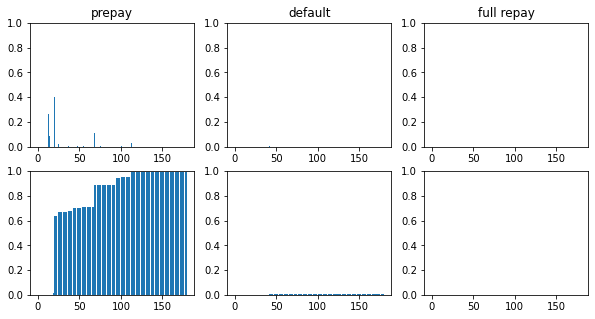

In [64]:
test_batch_data, test_batch_data_length, test_batch_event, test_batch_tte = next(iter(test_data_loader))

delta = 6 #This is variable

shortened_length = test_batch_data_length - delta
shortened_test_batch_data = copy.deepcopy(test_batch_data)

# we iterate over the whole batch and shorten their lengths accordingly
for i in range(len(test_batch_data_length)):
    left_censoring_index = int(shortened_length[i].item())
    right_censoring_index = int(test_batch_data_length[i].item())
    shortened_test_batch_data[i, left_censoring_index:right_censoring_index] = torch.zeros(delta, input_size)
    shortened_test_batch_data_length = copy.deepcopy(shortened_length)

shortened_test_batch_data = shortened_test_batch_data.to(DEVICE)
shortened_test_batch_data_length = shortened_test_batch_data_length.to(DEVICE)
test_batch_event = test_batch_event.to(DEVICE)

print("sample has length %d, but we concatenated to %d" % (test_batch_data_length[test_sample_index], shortened_test_batch_data_length[test_sample_index]))

test_output, test_first_hitting_time, test_attention_weights = DDHT(masked_data, shortened_test_batch_data_length)
test_first_hitting_time_argmax = test_first_hitting_time.argmax(dim=1)
model_event_prediction = test_first_hitting_time_argmax // MAX_LENGTH
model_tte_prediction = test_first_hitting_time_argmax % MAX_LENGTH

print("For the first sample of the test batch:")
print("sample has length %d" % shortened_test_batch_data_length[test_sample_index])
print("the model predicts the event %d at time %d" % (model_event_prediction[test_sample_index], model_tte_prediction[test_sample_index] + 1))

print("probability of prepay event = %.2f" % CIF_K_tau(test_first_hitting_time[test_sample_index], 0, MAX_LENGTH, shortened_test_batch_data_length[test_sample_index], MAX_LENGTH).item())
print("probability of default event = %.2f" % CIF_K_tau(test_first_hitting_time[test_sample_index], 1, MAX_LENGTH, shortened_test_batch_data_length[test_sample_index], MAX_LENGTH).item())
print("probability of full repay event = %.2f" % CIF_K_tau(test_first_hitting_time[test_sample_index], 2, MAX_LENGTH, shortened_test_batch_data_length[test_sample_index], MAX_LENGTH).item())

plot_fht_and_cif(test_first_hitting_time[test_sample_index], shortened_test_batch_data_length[test_sample_index], MAX_LENGTH)

### 7.5 Sensitivity to certain covariates

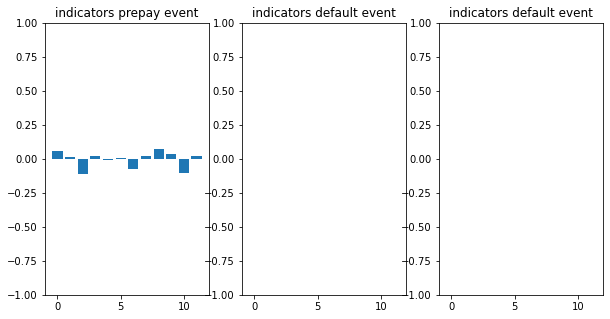

In [71]:
from utils import plot_gamma

delta = 6 #This is variable

min_gamma = torch.zeros(NUM_CAUSES, input_size)
max_gamma = torch.zeros(NUM_CAUSES, input_size)

for covariate_index in range(input_size):
    sensitivity_batch_data, sensitivity_batch_data_length, sensitivity_batch_event, sensitivity_batch_tte = next(iter(test_data_loader))

    #assuming it's minimum & maximum from the whole batch, not from a single sample
    batch_min = torch.tensor(float('Inf'))
    batch_max = (-1)*torch.tensor(float('Inf'))

    #we have to iterate over it otherwise, we catch the zero's that are meant as NANs in our case
    for sample, data_length in zip(sensitivity_batch_data, sensitivity_batch_data_length):
        sample_min = torch.min(sample[:data_length,covariate_index])
        sample_max = torch.max(sample[:data_length,covariate_index])

        if sample_min < batch_min:
            batch_min = sample_min

        if sample_max > batch_max:
            batch_max = sample_max

    min_sensitivity_batch_data = copy.deepcopy(sensitivity_batch_data)
    max_sensitivity_batch_data = copy.deepcopy(sensitivity_batch_data)

    #for safety we iterate again, since we otherwise fill in the zero's that are meant as NANs
    for sample_index, data_length in enumerate(sensitivity_batch_data_length):
        min_sensitivity_batch_data[sample_index,:data_length, covariate_index] = batch_min
        max_sensitivity_batch_data[sample_index,:data_length, covariate_index] = batch_max

    min_sensitivity_batch_data = min_sensitivity_batch_data.to(DEVICE)
    max_sensitivity_batch_data = max_sensitivity_batch_data.to(DEVICE)
    sensitivity_batch_data_length = sensitivity_batch_data_length.to(DEVICE)

    #for safety we iterate again, because the previous iteration might be absorbed by the one above that
    for sample_index, data_length in enumerate(sensitivity_batch_data_length):
        for cause_index in range(NUM_CAUSES):
            evaluation_time = min(int(data_length.item()) + delta, MAX_LENGTH)

            _, max_fht, _ = DDHT(max_sensitivity_batch_data[sample_index].unsqueeze(0), data_length)
            _, min_fht, _ = DDHT(min_sensitivity_batch_data[sample_index].unsqueeze(0), data_length)

            max_gamma[cause_index, covariate_index] += CIF_K_tau(max_fht[0], cause_index, evaluation_time, data_length, MAX_LENGTH).item()
            min_gamma[cause_index, covariate_index] += CIF_K_tau(min_fht[0], cause_index, evaluation_time, data_length, MAX_LENGTH).item()


gamma = (1/BATCH_SIZE)*(min_gamma - max_gamma)
plot_gamma(gamma, y_lim=[-1, 1])

print("The following covariate sensitivities are represented:")
for i, covariate in enumerate(allowed_covariates):
    print("Index %d represents covariate %s" % (i, covariate))